# Imports

In [ ]:
import math
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib
import numpy as np
from numpy.typing import ArrayLike
from typing import List
from typing import Tuple
from math import pi

# Practicum 2-1
Setting up a DC motor config.

## DCMotorConfig
**DCMotorConfig()** is a dataclass used to hold constant values for a DC motor. This makes life a lot easier when interacting with our DC motor model, as we only need to pass an instance of this class around, instead of six different float values. 

The advantage of using a **data class** over a vanilla python class is that it generates a lot of boilerplate for us. As can be seen in our data class below, there's no need to write an **__init__()** function because it is generated for us. While not used in our code, data classes also generate __repr__() functions so printing class instances show the data members inside instead of a memory address.

In [ ]:
from dataclasses import dataclass
@dataclass
class DCMotorConfig:
  """Store constant values for a DC Motor.
  
  R: float: resistance (Ohms)
  L: float: inductance (Henry)
  b: float: dampening (Nms)
  J: float: moment of inertia (kgm^2)
  K_m: float: back emf constant
  K_tau: float: motor torque constant"""
  R: float
  L: float
  b: float
  J: float
  Km: float
  Ktau: float

The equations for our DC motor:


$$L\frac{di(t)}{dt}+Ri(t)+K_m\dot{\theta}(t)=v(t) \tag{1}$$
$$J\ddot{\theta}+b\dot{\theta}=K_\tau i(t) \tag{2}$$

To evaluate the DC motor, I will first establish my state variables.
$$\begin{bmatrix}
x_1 \\ x_2 \\ x_3
\end{bmatrix}\equiv
\begin{bmatrix}
i \\
\theta \\
\dot{\theta}
\end{bmatrix}$$

$$\begin{bmatrix}
u
\end{bmatrix}\equiv
\begin{bmatrix}
v
\end{bmatrix}$$

We'll begin by plugging into **equation 1**:
$$L\dot{x_1}+Rx_1+K_mx_3=u$$
$$L\dot{x_1}=u-Rx_1-K_mx_3$$
$$\dot{x_1}=\frac{1}{L}u-\frac{R}{L}x_1-\frac{K_m}{L}x_3$$

Now we'll solve **equation 2**:
$$J\dot{x_3}+bx_3=K_\tau x_1$$
$$J\dot{x_3}=K_\tau x_1-bx_3$$
$$\dot{x_3}=\frac{K_\tau}{J} x_1-\frac{b}{J}x_3$$

Looking closely at our state variables, we can assert that:
$$\dot{x_2}=x_3$$

Now we have differential equations for all of our state variables:
\begin{align}
\dot{x_1}&=\frac{1}{L}u-\frac{R}{L}x_1-\frac{K_m}{L}x_3 \\
\dot{x_2}&=x_3 \\
\dot{x_3}&=\frac{K_\tau}{J} x_1-\frac{b}{J}x_3
\end{align}

Now we have our values for A and B:
$$\dot{x}=Ax+Bu \\
\begin{bmatrix}
\dot{x_1} \\ \dot{x_2} \\ \dot{x_3}
\end{bmatrix} =
\begin{bmatrix}
-\frac{R}{L} & 0 & -\frac{K_m}{L} \\
0 & 0 & 1 \\
\frac{K_\tau}{J} & 0 & \frac{b}{J}
\end{bmatrix}
\begin{bmatrix}
x_1 \\ x_2 \\ x_3
\end{bmatrix}+
\begin{bmatrix}
\frac{1}{L} \\
0 \\
0
\end{bmatrix}
\begin{bmatrix}
u
\end{bmatrix}$$

This equations for the DC motor is implemented in the **DCMotor** class below:

## DCMotor
My **DCMotor** class creates A and B matrices when initialized as derived above. When called, it returns the evaluation of $\dot{x}=Ax+Bu$.

In [ ]:
class DCMotor:
  def __init__(self, motor_cfg: DCMotorConfig) -> None:
    """Create A and B matrices from the motor_cfg."""
    self.A = np.array([[-1*motor_cfg.R/motor_cfg.L, 0, -1*motor_cfg.Km/motor_cfg.L],
                       [0, 0, 1],
                       [motor_cfg.Ktau/motor_cfg.J, 0, -1*motor_cfg.b/motor_cfg.J]])
    self.B = np.array([1/motor_cfg.L,
                       0,
                       0])
  def __call__(self, x: ArrayLike, u: float) -> ArrayLike:
    """Perform xdot = Ax+Ub."""
    a_term = np.dot(self.A,x)
    b_term = self.B*u
    return a_term + b_term

## Evaluation 1
Below, I tested some values to make sure that my DCMotor class is working. I tested the following configurations:

 Evaluation | State Values! Google collab wants to word wrap  | Input
-------| ------|-------- 
1 | $i=0.0A$, $\theta=0rad$, $\dot{\theta}=0rad/s$ | $v$ = 2.0V
2 | $i=0.0A$, $\theta=0rad$, $\dot{\theta}=0rad/s$ | $v$ = -2.0V
3 | $i=1.0A$, $\theta=0rad$, $\dot{\theta}=0rad/s$ | $v$ = 0.0V

In [ ]:
cfg = DCMotorConfig(R=1.8, L=0.85e-2, Km=4.6, Ktau=6.2, b=0.035, J=0.032)
dcmotor1 = DCMotor(motor_cfg=cfg)
print(f"Evaluation 1: {dcmotor1(x=np.array([0, 0, 0]), u=2.0)}")
print(f"Evaluation 2: {dcmotor1(x=np.array([0, 0, 0]), u=-2.0)}")
print(f"Evaluation 3: {dcmotor1(x=np.array([1, 0, 0]), u=0.0)}")

Evaluation 1: [235.29411765   0.           0.        ]
Evaluation 2: [-235.29411765    0.            0.        ]
Evaluation 3: [-211.76470588    0.          193.75      ]


### Reflection

1. State variables of zero, input of 2V. Output is positive current but no instantaneous position or velocity change.
  * Output matches expecations. There won't be instant
  position or velocity change, but there will be an instant current
  change from the potential difference being applied.
1. State variables of zero, input of -2V. Output is negative current but no instantaneous position or velocity change.
  * Output matches expecations. There won't be instant
    position or velocity change, but there will be an instant 
    current change from the potential difference being applied.
1. State variables of positive current, with position and velocity = 0.Output is negative current and positive velocity.
  * Output matches expectations. With a negative current initially, a velocity is expected.

## RK2 Integrator
Below is the RK2 integrator I built in Practicum 1, but updated to work with my DCMotor class.

In [ ]:
def rk2_integration(dyn_func: callable, 
                    u: callable, 
                    x_0: ArrayLike,
                    t_0: float, 
                    t_f: float, 
                    delta_t: float) -> list:
  """Perform Runge-Kutta integration.
  
  dyn_func: callable: dynamic function to integrate
  u: callable: input voltage(as a func of time)
  x_0: ArrayLike: initial conditions
  t_0: float: initial time
  t_f: float: final time=
  delta_t: float: time step size"""
  # Generate our t values
  t_vals = np.arange(start=t_0, 
                      stop=t_f+delta_t, 
                      step=delta_t)

  # Creating our result array
  x_vals = np.zeros([len(t_vals), np.shape(x_0)[0]])
  x_vals[0] = x_0

  for i in range(1, len(t_vals)):
    # Creating temp variables to ease equation-writing
    t = t_vals[i-1]
    x_k = x_vals[i-1]

    f_1 = dyn_func(x=x_k,u=u(t))
    f_2 = dyn_func(x=x_k + delta_t/2*f_1, u=u(t+delta_t/2))

    x_k_1 = x_k + delta_t*f_2
    x_vals[i] = x_k_1
  return t_vals, x_vals

## Unit Impulse
My **unit_impulse()** function returns 1 if t=0, else returns 0.

In [ ]:
def unit_impulse(t: float) -> float:
  """Returns 1 at t=0, else returns 0."""
  if t==0:
    return 1
  else:
    return 0

## Unit Step
My **unit_step()** function returns 1 if t>=0, else returns 0.

In [ ]:
def unit_step(t: float) -> float:
  """Returns 1 if t>=0, else returns 0."""
  if t>=0:
    return 1
  else:
    return 0

## Sinusoid
My **sinusoid()** function from Practicum 1.

In [ ]:
def sinusoid(t: float,
           A: float=2.0,
           omega: float=2.0 * math.pi,
           phi: float=0) -> float:
  """Return sinusoidal input function at t.
  
  t: float: time value to evaluate
  A: float: amplitude of the sin wave
  omega: float: period of the sin wave
  phi: float: phase shift of the sin wave"""
  return A * math.sin(omega * t + phi)

## Evaluation 2
Per usual, I wrote a function to do my plotting for me - which I probably spent more time writing than if I'd just done all the plotting manually, but hey. This makes it easier to try out different values! And it makes my code cleaner (probably).

In [ ]:
def evaluation_two(dyn_func: callable,
                   u: list,
                   x_0: list,
                   duration: float, 
                   delta_t: float,
                   titles: list):
  """Plot the DC motor with a list of initial conditions
  and input functions.
  
  dyn_func: callable: function to plot
  u: list[callable]: input voltage functions
  x_0: list[ArrayLike]: 2d array of initial conditions
  duration: float: length of time to integrate over
  delta_t: float: time step value to plot
  title: list[string]: titles for the plots"""
  
  # Create a new figure
  fig = plt.figure(figsize=(15, 5))
  axs = fig.subplots(2, len(u))
  plt.subplots_adjust(wspace=0.4,
                    hspace=0.4)
  plt.suptitle(f"Evaluation 2",
               fontsize='x-large')
  for i in range(len(u)):
    # plt.subplot(2, len(u), i+1)
    t_vals, x_vals = rk2_integration(dyn_func=dyn_func,
                                     u=u[i],
                                     x_0=x_0[i],
                                     t_0=0,
                                     t_f=duration,
                                     delta_t=delta_t)
    axs[0, i].plot(t_vals, [x[1] for x in x_vals])
    
    # Adding appropriate labels
    axs[0, i].set_title(titles[i])
    axs[0, i].set_xlabel("Time $(s)$")
    axs[0, i].set_ylabel("Position $(\Theta)$")

    # plt.subplot(2, len(b), i+(1+len(b)))
    axs[1, i].plot(t_vals, [x[2] for x in x_vals], color="red")
    
    # Adding appropriate labels
    axs[1, i].set_xlabel("Time $(s)$")
    axs[1, i].set_ylabel("Speed $(\dot{\Theta})$")

Below, I set up my lists and call my evaluation function.

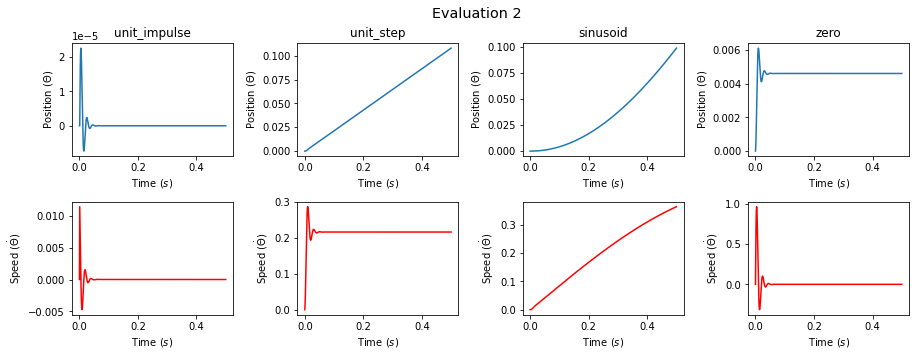

In [ ]:
from functools import partial
# lets me pass a sinusoid with parameters

x_0_list = np.array([[0,0,0],
                    [0,0,0],
                    [0,0,0],
                    [2.5,0,0]])

u_list = [unit_impulse,
          unit_step,
          partial(sinusoid, A=2.0, omega=2.0, phi=0),
          lambda u: 0]

titles = ["unit_impulse",
          "unit_step",
          "sinusoid",
          "zero"]
          
duration = 0.5
delta_t = 0.001
evaluation_two(dyn_func=dcmotor1,
               u=u_list,
               x_0=x_0_list,
               duration=duration, 
               delta_t=delta_t,
               titles=titles)

### Reflection

*   **unit_impulse**: Matches expectations. With initial conditions at zero, for a short impulse at t=0, I would expect to see a small jump in position and speed values with an eventual return to zero, which is what the plots indicate.
*   **unit_step**: Matches expectations. With initial conditions at zero, and a constant input of 1 after t=0, I would exect to see a linear increase in position and a constant speed after a ramp-up, and that's what the plots indicate.
*   **sinusoid**: Matches expectations. With initial conditions at zero, and a sinusoidal input, I would expect to see a nonlinear increase in position and speed, which is what the plots indicate.
*   **zero**: Matches expectations. With an initial current but speed and position at zero, and with no input, I would expect to see speed jump off and then return to zero, with position jumping up and eventually staying constant non-zero, which is what the plot indicates.

Overall, math-wise, this Practicum has yielded no real surprises thus far. The main surprise has been at how annoying **numpy** is about matrices with improper dimensions, and how and why it decides to use [broadcasting](https://numpy.org/doc/stable/user/basics.broadcasting.html) implicitly. That has added a lot of unecessary pain and anguish to what would otherwise be a pretty straightforward practicum.

I like the new structure of using data classes and classes - it's definitely a lot cleaner than passing groups of floats around. All told, I've enjoyed this practicum!

# Practicum 2-2
Weeks 2 and 3 of the project!

## DCMotorConfig
**DCMotorConfig()** is the same dataclass we made last week. Copied it here for easy reference.

In [ ]:
from dataclasses import dataclass
@dataclass
class DCMotorConfig:
  """Store constant values for a DC Motor.
  
  R: float: resistance (Ohms)
  L: float: inductance (Henry)
  b: float: dampening (Nms)
  J: float: moment of inertia (kgm^2)
  K_m: float: back emf constant
  K_tau: float: motor torque constant"""
  R: float
  L: float
  b: float
  J: float
  Km: float
  Ktau: float

## DCMotor
To better represent an input/output system with a PLANT, we've bifurcated our **DCMotor** class from last week into a **DCMotorDynamics** class and a **DCMotor** class. Now, our new **DCMotor** class calls **DCMotorDynamics** under the hood - abstracting it away. So, **DCMotorDynamics** now is what **DCMotor** was last week, and the new **DCMotor** contains an output function which returns $\theta$.

In [ ]:
class DCMotorDynamics:
  """Dynamics for a DC motor."""
  def __init__(self, motor_cfg: DCMotorConfig) -> None:
    """Create A and B matrices from the motor_cfg.
    
    motor_cfg: DCMotorConfig: dc motor config constants"""
    self.A = np.array([[-1*motor_cfg.R/motor_cfg.L, 0, -1*motor_cfg.Km/motor_cfg.L],
                       [0, 0, 1],
                       [motor_cfg.Ktau/motor_cfg.J, 0, -1*motor_cfg.b/motor_cfg.J]])
    self.B = np.array([1/motor_cfg.L,
                       0,
                       0])
  def __call__(self, x: ArrayLike, u: float) -> ArrayLike:
    """Perform xdot = Ax+Ub.
    
    x: ArrayLike: x
    u: float: input"""
    a_term = np.dot(self.A,x)
    b_term = self.B*u
    return a_term + b_term

class DCMotor:
  """Wrapper that abstracts away DCMotorDynamics."""
  def __init__(self, cfg: DCMotorConfig) -> None:
    """Inits dynamics.
    
    cfg: DCMotorConfig: dc motor config constants"""
    self.config = cfg
    self.dynamics = DCMotorDynamics(cfg)
  
  def output(self, x: ArrayLike) -> float:
    """Returns theta.
    
    x: ArrayLike: x"""
    return x[1]

## Evaluation 1
Now that we've refactored, we're re-doing Eval 1 from Practicum 2-1 to verify it works the same.

 Evaluation | State Values! Google collab wants to word wrap  | Input
-------| ------|-------- 
1 | $i=0.0A$, $\theta=0rad$, $\dot{\theta}=0rad/s$ | $v$ = 2.0V
2 | $i=0.0A$, $\theta=0rad$, $\dot{\theta}=0rad/s$ | $v$ = -2.0V
3 | $i=1.0A$, $\theta=0rad$, $\dot{\theta}=0rad/s$ | $v$ = 0.0V

In [ ]:
cfg = DCMotorConfig(R=1.8, L=0.85e-2, Km=4.6, Ktau=6.2, b=0.035, J=0.032)
dcmotor1 = DCMotor(cfg=cfg)
print(f"Evaluation 1: {dcmotor1.dynamics(x=np.array([0, 0, 0]), u=2.0)}")
print(f"Evaluation 2: {dcmotor1.dynamics(x=np.array([0, 0, 0]), u=-2.0)}")
print(f"Evaluation 3: {dcmotor1.dynamics(x=np.array([1, 0, 0]), u=0.0)}")

Evaluation 1: [235.29411765   0.           0.        ]
Evaluation 2: [-235.29411765    0.            0.        ]
Evaluation 3: [-211.76470588    0.          193.75      ]


### Reflection
These outputs match what I got for Practicum 2-1 Evaluation 1 - and I'll save both of us the work of copying + pasting that reflection. What matters is that our output here matches that, which means our refactor was successful.

## Integrator
We re-factored our numerical integration to make it more modular; following the lead of the [boost library.](https://www.boost.org/doc/libs/1_65_0/libs/numeric/odeint/doc/html/boost_numeric_odeint/odeint_in_detail/integrate_functions.html) Since every type of numerical integration requires some amount of duplicated boilerplate code, a better structure is to have a general "simulate" function that then calls a "stepper" function from within it. If we want to implement a different integrator function, now all we need to do is write a new "stepper".

### rk2_step
This is a stepper for second-order runge-kutta numerical integration. In Practicum 1, I fully explained the logic behind RK2, so I'll spare that here. In short, the stepper:

1. Computes $f_1$
1. Computes $f_2$
3. Computes $x_{k_1}$ using $f_1$ and $f_2$ and returns it

In [ ]:
from typing import Callable

def rk2_step(dyn_func: Callable,
             u_func: Callable,
             x: ArrayLike,
             t: float,
             delta_t: float) -> ArrayLike:
  """Computing f1, f2, and x_k_1.
  
  dyn_func: Callable: function being integrated
  u_func: Callable: input function
  x: ArrayLike: x_k value using to estimate x_k_1
  t: float: current time 
  delta_t: float: time step"""
  f_1 = dyn_func(x=x,u=u_func(t))
  f_2 = dyn_func(x=x + delta_t/2*f_1, u=u_func(t+delta_t/2))

  x_k_1 = x + delta_t*f_2
  return x_k_1

### simulate
This is our general numerical integration wrapper that does everything except for the stepping: it lets another function handle that. Currently, the stepper is not a parameter for the function, but that would be a super easy refactor. What this boilerplate all does I've gone in-depth with before so I'll spare that here, but, in short:

1. Generate t-value array from $t_0$ and $t_f$ values.
1. Create a x-value array from the shape of $x_0$.
1. Loop through the entire t-value array, calling the stepper on each iteration.

In [ ]:
def simulate(plant, 
             controller,
             x_0: ArrayLike,
             t_0: float,
             t_f: float,
             delta_t: float) -> Tuple[ArrayLike, ArrayLike]:
  """Generalized integrator function that uses a
  stepper function to be more modular.
  
  plant: what we are controlling
  controller: controller from which input is received
  x_0: ArrayLike: initial conditions
  t_0: float: initial time
  t_f: float: final time
  delta_t: float: time step"""
  # Generate our t values
  t_vals = np.arange(start=t_0, 
                      stop=t_f+delta_t, 
                      step=delta_t)

  # Creating our result array
  x_vals = np.zeros([len(t_vals), np.shape(x_0)[0]])
  x_vals[0] = x_0

  # Using our stepper
  for i in range(1, len(t_vals)):
    u_func = lambda t, measurement=plant.output(x_vals[i-1]): controller(measurement)
    x_vals[i] = rk2_step(dyn_func=plant.dynamics,
                         u_func=u_func,
                         x=x_vals[i-1],
                         t=t_vals[i-1],
                         delta_t=delta_t)
  return t_vals, x_vals

## DummmyController
This is just an example controller class that always returns 0.

In [ ]:
class DummyController:
  """Controller that always returns 0.0"""
  def __init__(self):
    """Set the value to zero."""
    self.value = 0.0
  def __call__(self, measurement: float):
    """Return the value.
    
    measurement: float: current output"""
    return self.value

## Evaluation 2
Here, we're evaluating with our dummy controller that constantly outputs zero. I used [this matplotlib article](https://matplotlib.org/stable/gallery/subplots_axes_and_figures/two_scales.html) to do two y-axes on one plot - and honestly I think it looks ugly. I will likely not be doing it again. I'm glad I tried it, though.

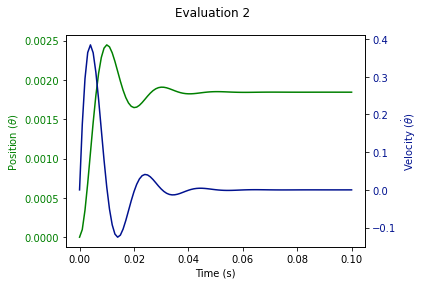

In [ ]:
delta_t=0.001
x_vals = np.array([1, 0, 0])

t_vals, x_vals = simulate(plant=dcmotor1,
                          controller=DummyController(),
                          x_0=x_vals,
                          t_0=0,
                          t_f=0.1,
                          delta_t=delta_t)
# position plot
color = 'green'
fig, ax1 = plt.subplots()
ax1.set_xlabel('Time (s)')
ax1.set_ylabel(r'Position ($\theta$)', color=color)
ax1.plot(t_vals, [x[1] for x in x_vals], color=color)
ax1.tick_params(axis='y', labelcolor=color)

# velocity plot
color = '#00118f'
ax2 = ax1.twinx()
ax2.set_ylabel(r"Velocity ($\dot{\theta}$)", color=color)
ax2.plot(t_vals, [x[2] for x in x_vals], color=color)
ax2.tick_params(axis='y', labelcolor=color)


fig.suptitle("Evaluation 2")
fig.tight_layout()
plt.show()

### Reflection
This output, as expected, matches my Evaulation 2 from Practicum 1-2: it matches my fourth (4th) plot from that evaulation exactly. I explained in that reflection why these outputs make sense so I'll spare that here. What matters is this output matching our previous evaluation shows the refactor hasn't broken anything, and so I'm good to move on to trying out some *controllers*!

Now that I've used custom colors to be easier on the eyes in that double plot, I don't mind it as much... hmm.... maybe I will use it in the future. 

## PID Controller
I'll utilize a similar class structure to the DC motor for the PID controller.

### PIDControllerConfig
Similar to **DCMotorConfig** - simply a dataclass to hold a bunch of constant values to avoid having to deal with five (5) separate float values all the time.

In [ ]:
@dataclass
class PIDControllerConfig:
  """Storing config constants for a PID controller.
  
  Kp: float: proportional constant
  Ki: float: integral constant
  Kd: float: derivative constant
  delta_t: float: time step
  setpoint: float: desired output / reference"""
  Kp: float
  Ki: float
  Kd: float
  delta_t: float
  setpoint: float

### PIDController
**PIDController** implementes a PID controller, utilizing the constant values stored in a **PIDControllerConfig** instance. 

* **init** stores the constant values for PID as member variables and 
initializes member variables for cumulative error and instantaneous previous error.
* **call** function implements PID control. It takes a measurement as an argument and returns the input value. It implements the following equations:

**Error:**
$$e(t)=r(t)-y(t)$$
**Input:**
$$u(t)=K_pe(t)+K_I\int_0^te(\tau)d\tau+K_D\frac{de(t)}{dt}$$

Essentially, a PID controller provides input for a system based on the error of the output: error being defined as the output - desired value. As can be seen in the $u(t)$ equation above, it has three components summed together: 

 Name | Integration Component| Numerical Calculation
-------| ------|-------- 
Proportional | $K_pe(t)$ | constant * current error
Integral | $K_I\int_0^te(\tau)d\tau$ | backwards rectangular estimation
Derivative | $K_D\frac{de(t)}{dt}$ | slope of current error

Each of these has their own constant so the influence each has on the final input value can be tweaked. This is investigated in Evaluation 3.

In [ ]:
class PIDController:
  def __init__(self, cfg: PIDControllerConfig) -> None:
    """Set up member variables.
    
    cfg: PIDControllerConfig: all the constants for a PID controller"""
    self.Kp = cfg.Kp
    self.Ki = cfg.Ki
    self.Kd = cfg.Kd
    self.delta_t = cfg.delta_t
    self.setpoint = cfg.setpoint

    self.cum_error = 0
    self.prior_error = 0

  def __call__(self, measurement: float) -> float:
    """Implementing PID.
    
    measurement: float: the current output of plant"""
    e = (self.setpoint-measurement)
    self.cum_error += e*self.delta_t

    p = self.Kp*e
    i = self.Ki*self.cum_error
    d = self.Kd*(e-self.prior_error)/self.delta_t

    self.prior_error = e
    
    return p+i+d

## Evaluation 3
Now we're tying everything together, combining our **DCMotor** with our **PIDController.**

## Plotting function
Per usual, I went over the top and wrote a function to do all my plotting. This time, it's so I can pass in lists of initial conditions, controllers, and plants to plot many different conditions side-by-side all at once, which I think is a good structure that I'll continue to use moving into the future. I've broken down the structure of my plotting functions before, so I won't needlessly repeat myself here.

In [ ]:
def plotting(plant: list,
             controller: list,
             x_0: list[ArrayLike],
             duration: float, 
             delta_t: float,
             title: str):
  """Plot theta and theta_dot of list of plant/controller/
  x_0 combinations.
  
  plant: list: plants to be plotted
  controller: list: controllers to be plotted
  x_0: list[ArrayLike]: 2d arrays of initial conditions to be plotted
  duration: float: length of time to integrate over
  delta_t: float: time step value to plot
  title: str: title for the plot"""
  # Create a new figure
  fig = plt.figure(figsize=(15, 5))
  axs = fig.subplots(2, len(controller))
  plt.subplots_adjust(wspace=0.4,
                    hspace=0.4)
  plt.suptitle(title,
               fontsize='x-large')
  
  for i in range(len(plant)):
    # plt.subplot(2, len(u), i+1)
    t_vals, x_vals = simulate(plant=plant[i],
                              controller=controller[i],
                              x_0=x_0[i],
                              t_0=0,
                              t_f=duration,
                              delta_t=delta_t)
    axs[0, i].plot(t_vals, [x[1] for x in x_vals])
    
    # Adding appropriate labels
    axs[0, i].set_title(f"$K_P$:{controller[i].Kp} " 
                        f"$K_I$:{controller[i].Ki} "
                        f"$K_D$:{controller[i].Kd}")
    axs[0, i].set_xlabel("Time $(s)$")
    axs[0, i].set_ylabel("Position $(\Theta)$")

    # plt.subplot(2, len(b), i+(1+len(b)))
    axs[1, i].plot(t_vals, [x[2] for x in x_vals], color="red")
    
    # Adding appropriate labels
    axs[1, i].set_xlabel("Time $(s)$")
    axs[1, i].set_ylabel("Speed $(\dot{\Theta})$")

Now, to initialize all the lists and call the function...

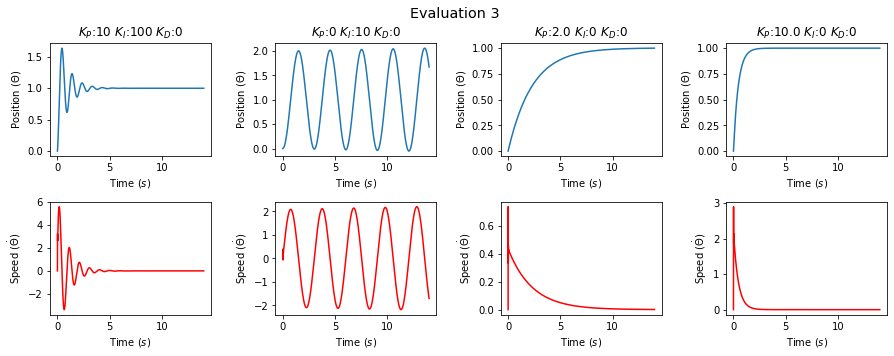

In [ ]:
# Input constants
title = "Evaluation 3"
duration = 14
delta_t=0.001
cfg = DCMotorConfig(R=1.8, L=0.85e-2, Km=4.6, Ktau=6.2, b=0.035, J=0.032)
dcmotor1 = DCMotor(cfg=cfg)

# Input lists
plant_list = [dcmotor1,
              dcmotor1,
              dcmotor1,
              dcmotor1]
controller_list = [
PIDController(cfg=PIDControllerConfig(Kp=10,
                                      Ki=100,
                                      Kd=0,
                                      delta_t=delta_t,
                                      setpoint=1.0)),
PIDController(cfg=PIDControllerConfig(Kp=0,
                                      Ki=10,
                                      Kd=0,
                                      delta_t=delta_t,
                                      setpoint=1.0)),
PIDController(cfg=PIDControllerConfig(Kp=2.0,
                                      Ki=0,
                                      Kd=0,
                                      delta_t=delta_t,
                                      setpoint=1.0)),
PIDController(cfg=PIDControllerConfig(Kp=10.0,
                                      Ki=0,
                                      Kd=0,
                                      delta_t=delta_t,
                                      setpoint=1.0)),]
x_vals = np.array([[1, 0, 0],
                   [1, 0, 0],
                   [1, 0, 0],
                   [1, 0, 0]])

# Calling the plotter
plotting(plant=plant_list,
         controller=controller_list,
         x_0=x_vals,
         duration=duration, 
         delta_t=delta_t,
         title=title)

### Reflection


1.   $K_p$ = 10, $K_I$ = 100, $K_d$ = 0
    * **under-damped**, ringing. It eventually gets to the correct output, but it takes a while, by constantly over and then under compensating. Based on how 3 and 4 look, it appears that including the integral component here is causing it to overshoot both positively and negatively.
1.   $K_p$ = 0, $K_I$ = 10, $K_d$ = 0
    * **not at all damped**, never gets near a steady state. This further supports my hypothesis from 1, as this just rings forever, seemingly. Without a proportional element, having just the integral element doesn't work at all.
1.   $K_p$ = 2.0, $K_I$ = 0, $K_d$ = 0
    * **over-damped**, takes a while to get to the target value. With just the proportional element, it never overshoots, it just hits an asymptote.
1.   $K_p$ = 10, $K_I$ = 0, $K_d$ = 0
    * **critically-damped**, gets to the desired value relatively quickly and stays there. This is similar to 3 except with the proportial coefficient being larger, it gets larger more quickly.


Overall, this has been a really cool practicum! Learning better ways to structure Python code is always appreciated, and I can really see the benefits here. I've known about data classes before, but this is my first time implementing them, and it's cool finally using them myself. This is also a great example of using interfaces instead of inheritance, which is something we had drilled into our heads in 428, but never clearly demonstrated.